# Embedding Model 

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip

--2022-01-18 05:42:05--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  20.7MB/s    in 0.3s    

2022-01-18 05:42:06 (20.7 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [ ]:
!unzip ./ml-1m.zip

Archive:  ./ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
#Dependencies
import pandas as pd
import numpy as np
import itertools

import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.express as px

import time
import tqdm


ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')
STATE_SIZE = 10

In [ ]:
#Loading datasets
ratings_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'users.dat'), 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'movies.dat'),encoding='latin-1').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = np.uint32)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
users_df = pd.DataFrame(users_list, columns=['UserID','Gender','Age','Occupation','Zip-code'])

In [ ]:
# 电影 ID 作为电影名称 
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [ ]:
len(movies_list)

3883

In [ ]:
movies_df.head(5)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
genres = ['Action',
        'Adventure',
        'Animation',
        "Children's",
        'Comedy',
        'Crime',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western']

让我们使用电影和流派之间以及电影和用户之间的相关性来嵌入电影、流派和用户。

在首先学习电影类型嵌入之后，使用学习的电影嵌入来学习电影用户嵌入。 

## 创建电影、流派、用户数据框

In [ ]:
# 创建电影 id 和流派数据框 
movies_genres_df = movies_df[['MovieID', 'Genres']]

In [ ]:
movies_genres_df.head(5)

,MovieID,Genres
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama
4,5,Comedy


In [ ]:
# 为每部电影分割 Gneres 后的索引
def _split_and_index(string):
    string = string.split('|')
    for i, s in enumerate(string):
        string[i] = genres.index(s)
    return string

movies_genres_df['Genres'] = movies_genres_df['Genres'].map(lambda x : _split_and_index(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
movies_genres_df.head(5)

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [ ]:
# 检查缺失值 
movies_genres_df.isnull().sum()

MovieID    0
Genres     0
dtype: int64

In [ ]:
# 检查特征值 
len(movies_genres_df['MovieID'])

3883

In [ ]:
movies_genres_df['MovieID'].nunique()

3883

In [ ]:
# 为每个用户创建电影评分数据框
user_movie_rating_df = ratings_df[['UserID','MovieID','Rating']]

In [ ]:
user_movie_rating_df.head(5)

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [ ]:
# 检查缺失值 
user_movie_rating_df.isnull().sum()

UserID     0
MovieID    0
Rating     0
dtype: int64

In [ ]:
user_movie_rating_df['UserID'].nunique()

6040

In [ ]:
user_movie_rating_df['MovieID'].nunique()

3706

##  Case1. 

## 创建模型 

In [ ]:
from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

### Movie Genre Embedding 模型 

In [ ]:
class MovieGenreEmbedding(tf.keras.Model):
    def __init__(self, len_movies, len_genres, embedding_size):
        super(MovieGenreEmbedding, self).__init__()
        self.m_g_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        self.g_embedding = Embedding(name='genre_embedding', input_dim=len_genres, output_dim=embedding_size)
        # dot product
        self.m_g_merge = Dot(name='movie_genre_dot', normalize=True, axes=1)
        # output
        self.m_g_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_g_input(x)
        memb = self.m_embedding(x[0])
        gemb = self.g_embedding(x[1])
        m_g = self.m_g_merge([memb, gemb])
#         m_g = self.reshape(m_g)
        return self.m_g_fc(m_g)

### User Embedding 模型 

In [ ]:
class UserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, embedding_size):
        super(UserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        m_u = self.m_u_merge([x[1], uemb])
        return self.m_u_fc(m_u)

## Data generator

### Movie Genre batch generator

1.   List item
2.   List item



In [ ]:
# movie genre data generator
movies_genres_df.head()

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [ ]:
movies_genres_dict = {m : g for m, g in zip(movies_genres_df["MovieID"],movies_genres_df["Genres"])}
movies_genres_dict[1]

[2, 3, 4]

In [ ]:
positive_m_g_pairs = []
negative_m_g_pairs = []
for movie in movies_genres_df["MovieID"]:
    for i in range(len(genres)):
        if i in movies_genres_dict[movie]:
            positive_m_g_pairs.append((movie, i, 1))
        else:
            negative_m_g_pairs.append((movie, i, 0))

In [ ]:
def generate_movie_genre_batch(positive_pairs, negative_pairs, batch_size, negative_ratio=0.5):
    
    batch = np.zeros((batch_size, 3))
    num_of_positive = batch_size-int(batch_size*negative_ratio)
    
    while True:
        idx = np.random.choice(len(positive_pairs), num_of_positive)
        positive_data = np.array(positive_pairs)[idx]
        for i, data in enumerate(positive_data):
            batch[i] = data
        
        idx = np.random.choice(len(negative_pairs), int(batch_size*negative_ratio))
        negative_data = np.array(negative_pairs)[idx]
        for i, data in enumerate(negative_data):
            batch[num_of_positive+i] = data
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [ ]:
# user movie data generator
user_movie_rating_df = user_movie_rating_df.apply(np.int32)
user_movie_rating_df.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### User batch generator

In [ ]:
modified_user_movie_rating_df = user_movie_rating_df.apply(np.int32)
index_names = modified_user_movie_rating_df[modified_user_movie_rating_df['Rating']<4].index
modified_user_movie_rating_df = modified_user_movie_rating_df.drop(index_names)
modified_user_movie_rating_df = modified_user_movie_rating_df.drop('Rating', axis=1)
u_m_pairs = modified_user_movie_rating_df.to_numpy()
u_m_pairs[:5]

array([[   1, 1193],
       [   1, 3408],
       [   1, 2355],
       [   1, 1287],
       [   1, 2804]], dtype=int32)

In [ ]:
positive_user_movie_dict = {u : [] for u in range(1, max(modified_user_movie_rating_df['UserID'])+1)}
for data in modified_user_movie_rating_df.iterrows():
    positive_user_movie_dict[data[1][0]].append(data[1][1])
positive_user_movie_dict[1]

[1193,
 3408,
 2355,
 1287,
 2804,
 594,
 919,
 595,
 938,
 2398,
 2918,
 1035,
 2791,
 2018,
 3105,
 2797,
 1270,
 527,
 48,
 1097,
 1721,
 1545,
 2294,
 3186,
 1566,
 588,
 1907,
 783,
 1836,
 1022,
 2762,
 150,
 1,
 1961,
 1962,
 2692,
 260,
 1028,
 1029,
 1207,
 2028,
 531,
 3114,
 608,
 1246]

In [ ]:
def generate_user_movie_batch(positive_pairs, batch_size, negative_ratio=0.5):
    batch = np.zeros((batch_size, 3))
    positive_batch_size = batch_size - int(batch_size*negative_ratio)
    max_user_id = max(modified_user_movie_rating_df['UserID'])+1
    max_movie_id = max(modified_user_movie_rating_df['MovieID'])+1
    
    while True:
        idx = np.random.choice(len(positive_pairs), positive_batch_size)
        data = positive_pairs[idx]
        for i, d in enumerate(data):
            batch[i] = (d[0], d[1], 1)
        
        while i+1 < batch_size:
            u = np.random.randint(1, max_user_id)
            m = np.random.randint(1, max_movie_id)
            if m not in positive_user_movie_dict[u]:
                i += 1
                batch[i] = (u, m, 0)
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

##  学习 

In [ ]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

MAX_EPOCH = 100
MOVIE_BATCH_SIZE = 128
MOVIE_STEP_PER_EPOCH = len(positive_m_g_pairs)//MOVIE_BATCH_SIZE

### Movie Genre Embedding 模型训练

In [ ]:
m_g_model = MovieGenreEmbedding(LEN_MOVIES, LEN_GENRES, EMBEDDING_SIZE)

In [ ]:
m_g_model([np.zeros((1)),np.zeros((1))])
m_g_model.summary()

Model: "movie_genre_embedding_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 movie_embedding (Embedding)  multiple                 395300    
                                                                 
 genre_embedding (Embedding)  multiple                 1900      
                                                                 
 movie_genre_dot (Dot)       multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  2         
                                                                 
Total params: 397,202
Trainable params: 397,202
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
m_g_train_loss = tf.keras.metrics.Mean(name='train_loss')
m_g_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

@tf.function
def m_g_train_step(m_g_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = m_g_model(m_g_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, m_g_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m_g_model.trainable_variables))

    m_g_train_loss(loss)
    m_g_train_accuracy(labels, predictions)

In [ ]:
m_batch, g_batch, m_g_label_batch = next(m_g_generator)
print(m_batch)
print(g_batch)
print(m_g_label_batch)

[ 881. 2103. 2532. 3293. 2844. 1520. 3452. 3198. 1501.  271. 3151. 2884.
 3552. 2006.  949. 2353.  149. 1319. 1419. 2532. 3751. 2329. 2634. 3697.
  338. 1124.  197. 2591. 3829. 2517.  532. 3599. 3402. 3320. 1246. 3510.
 2224. 3539. 2010. 2693. 2091.  653. 1043. 1179.  342. 1371. 2674.  306.
  159. 1149. 3407.  643.  635. 2380. 1631. 3169. 2285. 3888.  291.  819.
  688. 3926.  584. 1196. 3400. 2369. 2766. 2255.  636.  506. 1102.   82.
 2983. 1284. 1367. 1181. 1193. 2807. 3641. 2256. 3922.  566. 1953. 1578.
 1480. 2016.  595. 1058. 2093. 3341.  784. 2941. 1408. 2701. 2248.  510.
  279.  494. 3766. 1176.  787. 3174. 1987.  490. 3476.   12.   85. 2040.
 2077. 1233. 2720. 3501. 2447. 3617.  765. 3014. 2963.  980.  581. 3149.
 2654. 2877.  251. 1186. 1316.  236.  485.  420.]
[ 3.  3. 15.  4.  6.  9.  0. 16.  6.  7.  3.  9.  4.  0. 15. 15.  5.  3.
  6.  0.  4.  9.  2.  8.  9.  8. 13.  5. 13. 10. 10. 11.  6.  5.  7.  7.
 12.  6. 17.  6. 14. 14.  7.  5.  0.  0.  0. 12.  7.  7.  7.  4.  7.  4.
 

In [ ]:
# for log
m_g_losses = []

for epoch in range(MAX_EPOCH):
    
    m_g_generator = generate_movie_genre_batch(positive_m_g_pairs, negative_m_g_pairs, MOVIE_BATCH_SIZE, negative_ratio=0.5)
    
    for step in range(MOVIE_STEP_PER_EPOCH):
        # embedding layer update
        m_batch, g_batch, m_g_label_batch = next(m_g_generator)
        m_g_train_step([m_batch, g_batch], m_g_label_batch)
        
        print(f'{epoch} epoch, {step} steps, Loss: {m_g_train_loss.result():0.4f}, Accuracy: {m_g_train_accuracy.result() * 100:0.1f}')

    m_g_losses.append(m_g_train_loss.result())

0 epoch, 0 steps, Loss: 0.6762, Accuracy: 59.3
0 epoch, 1 steps, Loss: 0.6759, Accuracy: 59.4
0 epoch, 2 steps, Loss: 0.6757, Accuracy: 59.6
0 epoch, 3 steps, Loss: 0.6754, Accuracy: 59.7
0 epoch, 4 steps, Loss: 0.6753, Accuracy: 59.7
0 epoch, 5 steps, Loss: 0.6751, Accuracy: 59.8
0 epoch, 6 steps, Loss: 0.6749, Accuracy: 59.9
0 epoch, 7 steps, Loss: 0.6746, Accuracy: 60.0
0 epoch, 8 steps, Loss: 0.6744, Accuracy: 60.1
0 epoch, 9 steps, Loss: 0.6741, Accuracy: 60.2
0 epoch, 10 steps, Loss: 0.6737, Accuracy: 60.4
0 epoch, 11 steps, Loss: 0.6734, Accuracy: 60.5
0 epoch, 12 steps, Loss: 0.6732, Accuracy: 60.6
0 epoch, 13 steps, Loss: 0.6730, Accuracy: 60.7
0 epoch, 14 steps, Loss: 0.6727, Accuracy: 60.8
0 epoch, 15 steps, Loss: 0.6723, Accuracy: 61.0
0 epoch, 16 steps, Loss: 0.6721, Accuracy: 61.1
0 epoch, 17 steps, Loss: 0.6718, Accuracy: 61.2
0 epoch, 18 steps, Loss: 0.6716, Accuracy: 61.3
0 epoch, 19 steps, Loss: 0.6713, Accuracy: 61.5
0 epoch, 20 steps, Loss: 0.6710, Accuracy: 61.6
0 

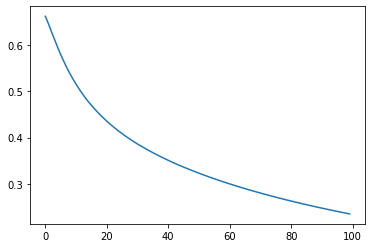

In [ ]:
plt.plot(m_g_losses)

In [ ]:
!mkdir ./save_weights

In [ ]:
m_g_model.save_weights('./save_weights/m_g_model_weights.h5')

### User Movie Embedding 模型训练

In [ ]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [ ]:
u_m_model = UserMovieEmbedding(LEN_USERS, EMBEDDING_SIZE)

In [ ]:
u_m_model([np.zeros((1)),np.zeros((1,100))])
u_m_model.summary()

Model: "user_movie_embedding_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 user_embedding (Embedding)  multiple                  604100    
                                                                 
 movie_user_dot (Dot)        multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  2         
                                                                 
Total params: 604,102
Trainable params: 604,102
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
u_m_train_loss = tf.keras.metrics.Mean(name='train_loss')
u_m_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def u_m_train_step(u_m_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = u_m_model(u_m_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, u_m_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, u_m_model.trainable_variables))

    u_m_train_loss(loss)
    u_m_train_accuracy(labels, predictions)

In [ ]:
# for log
u_m_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    u_m_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(u_m_generator)
        m_batch = m_g_model.get_layer('movie_embedding')(m_batch)
        u_m_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {u_m_train_loss.result():0.4f}, Accuracy: {u_m_train_accuracy.result() * 100:0.1f}')

    u_m_losses.append(u_m_train_loss.result())

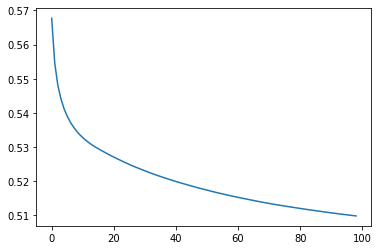

In [ ]:
plt.plot(u_m_losses)

In [ ]:
u_m_model.save_weights('./save_weights/u_m_model_weights.h5')

### 可视化

In [ ]:
# # 加载模型权重 
# model.load_weights('./save_weights/embedding_24epoch.h5')

In [ ]:
# embedded movie dataframe
embedded_movie = movies_genres_df['MovieID'].apply(m_g_model.get_layer('movie_embedding'))
columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)
for data in embedded_movie:
    embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
embedded_movie_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.017013,-0.005583,-0.011875,-0.123731,0.074917,0.044440,0.118054,0.052017,0.027882,-0.026133,-0.006269,0.011187,0.003939,0.030848,0.005635,0.049062,0.018664,-0.121760,0.184952,-0.066322,-0.134754,0.098821,0.040006,-0.132091,-0.019906,0.091433,0.012989,-0.053088,0.021702,-0.016117,0.178279,-0.064691,0.017878,0.076238,-0.078197,-0.159881,0.072932,0.052900,0.005337,0.054786,...,0.090538,-0.053381,0.075820,-0.034348,-0.034985,0.088229,-0.026049,0.036226,0.021115,-0.058492,-0.019574,0.003056,-0.091289,-0.031183,-0.052602,0.042232,0.015089,-0.033467,0.027507,0.119739,-0.088480,-0.009543,0.017560,-0.039070,0.132859,-0.104410,0.000299,-0.010822,0.035332,0.068440,-0.051532,0.025048,0.165523,-0.039831,-0.014257,0.056564,0.075675,-0.031851,-0.154731,0.038321
1,0.035554,-0.014876,0.001966,0.002244,0.010952,0.012326,0.107402,-0.099266,0.012705,-0.122024,-0.117226,-0.051889,-0.140579,0.017469,-0.044987,-0.008803,0.051950,0.043851,-0.002090,0.067572,0.037308,0.112289,-0.008164,0.113411,-0.052632,0.092459,0.013795,0.057604,-0.076986,-0.009972,-0.001168,-0.048963,-0.031430,-0.036087,0.049216,-0.097398,-0.001046,0.141271,-0.111195,0.039879,...,-0.036072,-0.026788,0.121421,-0.002019,-0.035724,-0.082431,0.036923,0.066323,-0.058244,-0.115384,-0.078688,-0.027645,-0.168785,0.032076,0.027211,0.087282,0.078545,-0.040161,0.072940,0.057436,0.004433,-0.080113,0.005181,0.012399,0.056307,-0.001136,0.036412,-0.012411,0.106709,0.017510,-0.075256,-0.073073,-0.027492,-0.079708,0.109945,-0.004837,0.001436,-0.118716,-0.151157,0.023400
2,-0.118838,-0.020854,-0.066717,-0.000456,-0.022366,0.073042,0.000386,0.132047,0.053358,0.111101,0.007648,0.071886,-0.020057,-0.109189,-0.006347,-0.117492,0.133196,0.044569,0.053426,0.083687,-0.078684,-0.001734,-0.058564,-0.010112,-0.052671,0.040991,0.028289,-0.080636,-0.080227,-0.030868,-0.009134,0.076328,0.054492,0.014532,-0.076137,-0.060947,-0.034667,-0.094669,0.080402,0.113484,...,0.072772,0.000623,-0.073167,-0.114022,-0.028003,0.020375,-0.017118,0.021423,0.100527,-0.077439,0.041607,0.072897,-0.056234,-0.080152,-0.127062,0.102397,0.022924,0.072021,0.029435,0.055764,0.095428,0.030164,-0.031861,0.072130,0.078045,-0.003099,-0.014876,0.003006,-0.039439,0.003557,0.054355,0.090754,-0.009676,0.006476,-0.132057,0.017147,-0.057990,0.010402,-0.023221,0.104188
3,-0.050580,-0.090323,-0.019032,-0.111370,0.007091,-0.001870,0.014297,0.055901,0.111077,0.097968,0.091042,0.004749,0.013152,-0.100930,0.103566,-0.085650,0.074180,0.022578,0.012800,0.055571,0.017224,0.104245,0.092751,-0.026313,0.074333,0.033431,-0.081864,-0.032239,-0.019146,0.058782,-0.018102,0.036858,-0.045364,0.103202,0.004225,0.005494,0.064183,-0.071544,0.100746,0.033650,...,0.074012,-0.012097,-0.047858,-0.110023,0.064527,-0.057880,-0.100709,-0.086766,0.060285,0.048764,0.121067,0.066766,0.018414,0.024475,-0.066411,0.088517,-0.127321,0.106436,0.117184,-0.017142,0.057644,0.107152,-0.116304,-0.033667,0.011004,-0.120679,0.043097,-0.084966,-0.068853,0.071841,0.090679,0.015222,0.114075,0.117493,-0.085827,-0.012137,0.019526,0.011202,-0.087275,0.073556
4,-0.055253,-0.120230,-0.086287,-0.076163,0.077065,0.046857,0.041496,0.083432,0.104715,0.020967,0.041146,-0.016993,0.065648,-0.034058,0.020507,-0.032675,0.087864,-0.054221,0.090087,0.039573,-0.074541,0.051032,0.015832,-0.110486,-0.020247,0.023964,-0.005947,-0.060987,-0.038816,-0.014617,0.056905,0.037901,0.068995,0.096051,-0.063148,-0.064312,0.077494,-0.010159,0.027821,0.026085,...,0.011714,0.076163,-0.001647,-0.031475,0.030945,0.032217,-0.058998,-0.064032,0.127537,-0.021406,0.041889,-0.003194,-0.079966,-0.079395,-0.067742,0.038986,-0.053801,0.056394,0.081059,0.047745,0.019678,0.142986,-0.114881,0.021773,0.096482,-0.051051,-0.057948,-0.086990,-0.023400,0.099017,0.012977,0.098549,0.068446,0.079647,-0.062125,-

In [ ]:
# 使用 PCA 降维
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

,0,1,Title,Genres
0,7.338761,-1.185810,Toy Story (1995),Animation|Children's|Comedy
1,4.202719,4.860532,Jumanji (1995),Adventure|Children's|Fantasy
2,2.927299,-4.320269,Grumpier Old Men (1995),Comedy|Romance
3,-2.214703,-7.227244,Waiting to Exhale (1995),Comedy|Drama
4,5.720616,-4.481315,Father of the Bride Part II (1995),Comedy


In [ ]:
# 可视化 
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
# 使用 T-SNE 降维
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,x,y,Title,Genres
0,2.779095,-3.812068,Toy Story (1995),Animation|Children's|Comedy
1,-12.777101,6.282612,Jumanji (1995),Adventure|Children's|Fantasy
2,25.345081,29.713554,Grumpier Old Men (1995),Comedy|Romance
3,-33.474998,-42.182533,Waiting to Exhale (1995),Comedy|Drama
4,51.417240,3.490679,Father of the Bride Part II (1995),Comedy


In [ ]:
# 可视化
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
# embedded user dataframe
embedded_user = users_df['UserID'].apply(np.int32).apply(u_m_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.384813,-0.355603,-0.059689,-0.399958,-0.275491,0.093543,0.927181,0.294001,-0.017679,0.610538,-0.321456,0.113030,-0.021798,0.425792,-0.397399,-0.327731,0.135733,-0.062028,-0.416089,0.085544,-0.480735,-0.062362,-0.006741,0.158478,0.461082,-0.002446,-0.004812,0.578128,0.148221,-0.093749,0.449366,-0.024455,-0.083033,0.539712,-0.031187,-0.771715,-0.038506,0.173246,0.176067,0.237874,...,0.081566,0.025823,0.053808,0.015715,-0.120339,-0.270910,-0.466105,0.030987,0.518310,0.965269,-0.260919,-0.769213,-0.200879,0.391159,0.417431,0.306006,-1.067705,0.344668,0.177267,-0.175389,0.455621,-0.144750,-0.164200,0.061448,0.557775,-0.614887,-0.616054,-0.481926,0.921018,0.457982,-0.671232,-0.513203,0.375199,-0.284176,0.238477,0.465692,-0.094423,0.042038,0.261816,-0.592207
1,-0.170557,0.134442,0.214247,-0.248407,-0.030892,0.129677,0.173743,0.169498,-0.359111,-0.305756,0.291094,-0.044804,-0.421620,0.222172,0.035483,0.046922,0.639051,-0.200808,0.314202,0.397692,0.164610,-0.170164,0.256998,-0.064214,-0.163204,-0.025772,0.646646,0.913279,-0.171406,0.002016,-0.588704,-0.118423,-0.113971,0.564430,-0.224358,-0.154144,0.465995,0.097194,-0.425636,-0.533851,...,0.203046,0.321378,-0.325011,-0.246343,-0.231560,-0.606152,-0.208962,0.483505,0.028913,0.283410,-0.833454,0.078529,0.080443,-0.056888,0.482968,-0.037717,-0.705067,0.092985,0.086609,0.015940,0.087077,0.099002,0.963015,-0.463895,0.090259,-0.421626,-0.178992,-0.231409,0.784135,0.178466,0.220235,-0.216692,0.242574,0.298134,0.036822,0.222134,0.146181,0.022861,1.011537,-1.110785
2,0.194562,-0.199897,-0.323533,-0.098577,0.085008,0.657925,-0.087303,0.354064,-0.030133,-0.118533,0.238110,-0.632071,0.251878,-0.157394,-0.425824,-0.674364,0.106919,-0.331569,0.741552,0.272835,-0.509451,0.197250,0.029049,-0.178269,-0.841580,-0.042361,0.442255,0.006535,0.012705,1.104691,-0.620045,0.149351,-1.137307,-0.699505,-1.325009,0.024694,0.459303,0.743352,-0.138015,0.122482,...,0.702605,0.111745,-0.140620,0.380195,0.653954,-0.232587,-0.960037,0.308646,0.165928,-0.234882,-0.629103,0.650315,-0.724679,0.131314,0.073711,-0.637744,-0.519006,0.922993,0.152741,-1.406986,-0.039990,-0.056926,0.803592,-0.549935,0.303704,-0.214117,0.843302,0.012358,0.531412,0.751465,-0.046360,-0.814045,-0.607202,-0.207374,0.222327,0.674234,-0.557858,0.334841,0.192121,-0.445427
3,-0.037218,-0.441509,-0.360946,0.880737,0.403627,0.919534,0.648209,1.525825,-0.113796,-0.331940,-0.240997,0.093192,-0.122743,0.178105,-0.251188,-1.541120,0.216493,0.195029,0.357145,0.473400,-0.531109,0.330364,-0.050376,-0.482128,-0.219309,1.613355,0.249512,0.696484,0.582493,-0.449176,0.029345,-0.381676,-0.179971,0.730095,-0.902111,0.438727,0.811534,-0.043202,0.351592,0.438230,...,0.844531,-0.369727,1.034118,0.178654,-0.545040,-0.915467,-0.778932,-0.009165,-0.364313,0.160976,0.064574,-0.076080,-0.031966,0.242741,-0.008033,1.084596,-0.457425,0.737047,-0.376584,-0.284128,1.138013,-0.328028,0.429878,-0.114098,-0.119613,-1.113076,-0.170367,-0.594576,0.661465,0.519235,-0.334943,-0.284591,0.559533,-0.306324,0.795567,0.374229,-1.066179,-0.134167,0.800129,-1.197769
4,-0.610236,-0.078108,-0.114094,-0.031196,-0.225012,-0.290170,0.330463,-0.035584,0.009195,0.169935,-0.180443,-0.240153,-0.202129,-0.269142,-0.171741,0.313534,0.393617,0.114763,-0.434944,-0.035674,0.394594,-0.383807,-0.282240,-0.205707,0.127265,-0.214625,-0.098238,0.191974,-0.548048,0.097809,-0.464994,0.309894,-0.504779,0.382594,-0.480459,-0.555710,0.148084,-0.140503,-0.819845,-0.431354,...,0.092332,-0.096611,-0.204450,-0.115325,-0.251976,-0.210402,0.022334,0.028158,-0.007752,0.348821,-0.549357,0.129814,0.147143,-0.363115,0.289556,0.029258,-0.649738,-0.275120,0.193333,-0.058708,-0.446553,-0.354459,0.155349,-0.098318,-0.106974,-0.116453,-0.062918,-0.120833,-0.007674,-0.370725,0.038856,-0.203962,-0

In [ ]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
# 使用 PCA 降维
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

user_scaled = StandardScaler().fit_transform(embedded_user_df)
pca = PCA(n_components=2)
pca.fit(user_scaled)
user_pca = pca.transform(user_scaled)
pca_columns=[f'{n}' for n in range(2)]
user_df_pca = pd.DataFrame(user_pca,columns=pca_columns)
user_df_pca = pd.concat([user_df_pca, users_df["Gender"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Age"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Zip-code"]], axis=1)
user_df_pca.head()

,0,1,Gender,Age,Zip-code
0,-1.936737,-0.511942,F,1,48067
1,1.291020,-0.391837,M,56,70072
2,-3.465779,1.625262,M,25,55117
3,-6.790569,5.360387,M,45,02460
4,0.499657,-3.788412,M,25,55455


In [ ]:
# 可视化 
fig = px.scatter(user_df_pca, x='0', y='1', hover_data=user_df_pca)
fig.show()

In [ ]:
# 使用 T-SNE 降维
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,x,y,Gender,Age,Zip-code
0,18.946819,13.199451,F,1,48067
1,12.914835,-19.379364,M,56,70072
2,-32.433853,23.760681,M,25,55117
3,-39.312012,44.968822,M,45,02460
4,3.744903,0.517772,M,25,55455


In [ ]:
# 可视化 
fig = px.scatter(tsne_df, x='x', y='y', hover_data=tsne_df)
fig.show()

##  Case2.

In [ ]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

In [ ]:
class TestUserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, len_movies, embedding_size):
        super(TestUserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        memb = self.m_embedding(x[1])
        m_u = self.m_u_merge([memb, uemb])
        return self.m_u_fc(m_u)

In [ ]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [ ]:
test_model = TestUserMovieEmbedding(LEN_USERS, LEN_MOVIES, EMBEDDING_SIZE)

test_model([np.zeros((1)),np.zeros((1))])
test_model.summary()

Model: "test_user_movie_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 user_embedding (Embedding)  multiple                  604100    
                                                                 
 movie_embedding (Embedding)  multiple                 395300    
                                                                 
 movie_user_dot (Dot)        multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  2         
                                                                 
Total params: 999,402
Trainable params: 999,402
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
test_train_loss = tf.keras.metrics.Mean(name='train_loss')
test_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def test_train_step(test_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = test_model(test_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, test_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, test_model.trainable_variables))

    test_train_loss(loss)
    test_train_accuracy(labels, predictions)

In [ ]:
# for log
test_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    test_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(test_generator)
        test_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {test_train_loss.result():0.4f}, Accuracy: {test_train_accuracy.result() * 100:0.1f}')
        # print('{} epoch, Batch size : {}, {} steps, Loss: {}, Accuracy: {}'.format(epoch,batch_size,step,tf.round(test_train_loss.result(),3),tf.round(test_train_accuracy.result() * 100,3)))

    test_losses.append(test_train_loss.result())

Streaming output truncated to the last 5000 lines.
1 epoch, Batch size : 128, 4698 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4699 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4700 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4701 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4702 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4703 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4704 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4705 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4706 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4707 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4708 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4709 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4710 steps, Loss: 0.3168, Accuracy: 86.4
1 epoch, Batch size : 128, 4711 steps, Loss: 0.3168, Accuracy: 86

KeyboardInterrupt: ignored

In [ ]:
# embedded movie dataframe 
embedded_movie = movies_genres_df['MovieID'].apply(test_model.get_layer('movie_embedding'))
columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)
for data in embedded_movie:
    embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
embedded_movie_df.head()

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

# 可视化
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
# 使用 T-SNE 降维
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

# 可视化
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
# embedded user dataframe
embedded_user = users_df['UserID'].apply(np.int32).apply(test_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.233391,-0.109864,0.013611,-0.304482,0.172499,0.118033,-0.155714,0.018504,-0.306459,0.184499,0.181000,0.165103,-0.273281,0.062448,-0.255037,0.289537,-0.171362,0.110719,0.464695,0.181938,-0.162539,0.139115,0.316535,0.356975,-0.054847,-0.054504,-0.158649,0.016192,0.222748,0.603876,0.019835,0.391438,0.154551,0.064726,0.265925,-0.398856,0.114242,0.035958,0.037815,-0.026102,...,0.042151,-0.156164,-0.515926,-0.066718,-0.176131,0.132004,-0.092589,0.156861,-0.332660,0.209512,0.240437,0.014332,0.173877,0.141374,0.157535,-0.178213,-0.111563,0.006531,-0.164117,-0.153111,-0.174525,-0.298491,-0.098399,0.175371,-0.137181,-0.653337,-0.413374,0.034182,-0.090733,-0.352848,0.099516,-0.327587,0.356758,0.134922,0.261001,-0.051358,0.263320,0.080325,0.234983,-0.172194
1,0.128026,-0.222741,0.091286,-0.079249,-0.076300,-0.104449,-0.100042,-0.136356,-0.204136,0.057045,0.226717,0.057157,-0.665132,-0.148887,0.163450,0.093011,-0.151675,0.128278,-0.059701,0.213176,0.043299,0.101605,-0.211885,0.368761,0.399669,-0.153166,0.150978,-0.269699,0.066649,0.094034,0.052864,-0.085415,0.188934,-0.151756,0.380274,-0.352341,0.114150,-0.057242,0.136632,0.194642,...,-0.097234,-0.145665,-0.325962,-0.430000,-0.411694,0.077336,-0.427077,-0.115095,-0.163306,0.449279,-0.081957,-0.079528,-0.115869,0.061127,0.153800,0.121290,0.238340,0.324138,-0.177012,0.206072,-0.121338,-0.083762,0.052012,0.069883,-0.031608,-0.312854,0.302873,0.065537,-0.280386,0.253689,0.145780,-0.181283,-0.070112,0.180210,0.435370,0.206127,0.506389,-0.043582,0.208261,-0.193719
2,0.139275,-0.147791,0.196461,-0.568943,-0.172050,-0.132836,-0.038752,-0.231399,-0.086929,0.465864,0.233106,-0.183399,-0.377709,-0.150455,0.165219,0.167962,-0.470568,-0.102897,0.334877,0.432101,0.069150,-0.016007,0.056689,-0.006721,0.124769,-0.272893,-0.077654,-0.156498,0.475728,0.134848,0.044211,-0.034281,0.056482,0.153530,-0.008443,-0.257468,-0.038654,-0.030322,0.041946,-0.037917,...,0.011176,-0.168855,-0.194908,-0.314794,0.066955,0.158479,0.337998,-0.258125,-0.211131,0.031381,0.000671,0.118438,0.001398,-0.107349,-0.170222,-0.241367,0.103336,0.204101,-0.331155,-0.077634,0.000619,-0.556628,0.141915,0.360027,0.518317,-0.340860,-0.230519,0.135624,0.254338,-0.309566,-0.084885,-0.114606,-0.218904,-0.083895,0.290745,0.422935,-0.136789,0.337791,0.165998,-0.235353
3,-0.148971,-0.097567,0.355299,-0.299917,0.207794,-0.083695,-0.248098,-0.406722,0.218936,0.066805,0.174853,0.099443,-0.625356,-0.122315,0.189714,0.017920,-0.309902,-0.068788,-0.003762,0.204741,-0.485802,-0.009267,0.189824,0.196909,-0.151173,-0.079388,0.156068,-0.248528,0.335694,0.023922,0.251765,-0.171228,0.064334,-0.116343,0.274919,0.050248,0.289113,-0.420256,-0.001385,0.131609,...,-0.429462,-0.186524,-0.154080,-0.302571,-0.154466,0.204025,0.178015,-0.311532,0.191744,0.100694,0.155815,0.150846,-0.201310,0.036690,-0.006504,-0.686788,0.187490,0.085654,-0.166856,0.154456,-0.050112,-0.169243,0.342196,0.337099,0.284737,-0.383097,-0.352724,-0.148576,0.015375,0.133145,0.155072,-0.786926,0.531605,0.174287,-0.229531,0.657418,0.175664,0.422617,0.105771,0.047501
4,-0.103142,-0.086535,0.052911,-0.030838,-0.085526,0.172850,0.085378,0.026801,0.240716,0.107706,-0.234544,0.023022,-0.134221,-0.098354,0.061037,0.046378,-0.191619,0.411093,0.210965,0.354115,-0.111125,-0.195249,0.211515,-0.214458,0.228371,0.279309,0.791974,0.135483,-0.115404,0.667166,-0.065279,0.552114,0.014845,0.019565,-0.091876,0.102014,-0.289186,-0.281665,-0.040247,0.492296,...,-0.006523,-0.089682,0.168056,-0.198156,0.008082,-0.589764,-0.121500,0.098653,0.147506,-0.134913,-0.218590,0.049888,-0.307547,0.054504,0.022698,0.049067,-0.252597,0.254185,-0.139959,-0.310032,0.390766,0.038864,-0.337326,-0.033731,0.096333,0.121121,-0.114379,-0.051435,-0.023075,0.282336,-0.207535,-0.409706,0.546043,0.506060,0

In [ ]:
# 使用 T-SNE 降维
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,x,y,Gender,Age,Zip-code
0,1.029272,43.854126,F,1,48067
1,0.520201,2.223750,M,56,70072
2,-12.874623,4.492972,M,25,55117
3,-12.111417,18.019377,M,45,02460
4,5.291888,-24.498575,M,25,55455


In [ ]:
# 可视化
fig = px.scatter(tsne_df, x='x', y='y', color='Age', hover_data=tsne_df)
fig.show()

In [ ]:
test_model.save_weights('./save_weights/user_movie_at_once.h5')